## Importing Dependencies

In [1]:
# LangGraph agentic AI pipeline for structured data analysis
from langchain.agents import create_sql_agent
from langchain.agents.agent_toolkits import SQLDatabaseToolkit
from langchain.sql_database import SQLDatabase
from langgraph.graph import StateGraph, END, START
import os
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings
import os
from dotenv import load_dotenv
from tqdm.autonotebook import tqdm as notebook_tqdm
from typing import TypedDict, Literal
from pydantic import BaseModel
from langchain_experimental.utilities import PythonREPL
from langchain_core.tools import tool
from typing import Annotated
from typing import Literal
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, END
from langgraph.types import Command
from langgraph.graph.message import add_messages
from langchain_core.messages import SystemMessage


/var/folders/2l/h792r8g56wx6dpj_tzgmky7m0000gn/T/ipykernel_90912/408873642.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm as notebook_tqdm


## Load environment variables

In [2]:

## Load environment variables
load_dotenv()
groq_api_key=os.getenv("GROQ_API_KEY")
os.environ["HF_TOKEN"]=os.getenv("HF_TOKEN")

## Load CSV files to SQLite DB

In [3]:
import pandas as pd
import sqlite3

def csv_to_sqlite(csv_file_path, sqlite_db_path, table_name):
    # Load CSV into DataFrame
    df = pd.read_csv(csv_file_path)

    # Connect to SQLite database (creates it if it doesn't exist)
    conn = sqlite3.connect(sqlite_db_path)

    # Write the DataFrame to SQLite table
    df.to_sql(table_name, conn, if_exists='replace', index=False)

    # Close the connection
    conn.close()

    print(f"CSV '{csv_file_path}' has been imported into SQLite DB '{sqlite_db_path}' as table '{table_name}'.")




In [4]:
csv_to_sqlite('customer_features_long_format.csv', 'nqes.db', 'customer_features_long_format')


CSV 'customer_features_long_format.csv' has been imported into SQLite DB 'nqes.db' as table 'customer_features_long_format'.


In [5]:
csv_to_sqlite('customer_scores_long_format.csv', 'nqes.db', 'customer_scores_long_format')

CSV 'customer_scores_long_format.csv' has been imported into SQLite DB 'nqes.db' as table 'customer_scores_long_format'.


In [6]:
# Load SQLite DB
db = SQLDatabase.from_uri("sqlite:///nqes.db")

In [7]:
print(db.get_usable_table_names())


['customer_features_long_format', 'customer_scores_long_format']


In [8]:
print(db.get_table_info(table_names=db.get_usable_table_names()))


CREATE TABLE customer_features_long_format (
	customer_id TEXT, 
	feature_name TEXT, 
	feature_value REAL
)

/*
3 rows from customer_features_long_format table:
customer_id	feature_name	feature_value
CUST_000	rsrp	43.2
CUST_000	sinr	52.32
CUST_000	shap_rsrp	2.93
*/


CREATE TABLE customer_scores_long_format (
	customer_id TEXT, 
	score_name TEXT, 
	score_value REAL
)

/*
3 rows from customer_scores_long_format table:
customer_id	score_name	score_value
CUST_000	main_score	4.37
CUST_000	signal_quality_subscore	9.56
CUST_001	main_score	7.59
*/


In [9]:
## Let's read the data and check whether it got populated in DB or not
!sqlite3 nqes.db "SELECT * FROM customer_features_long_format LIMIT 5 "

CUST_000|rsrp|43.2
CUST_000|sinr|52.32
CUST_000|shap_rsrp|2.93
CUST_000|shap_sinr|-7.14
CUST_001|rsrp|68.66


# Load LLM

In [292]:
# Load LLM
load_dotenv()
llm = ChatGroq(groq_api_key=os.getenv("GROQ_API_KEY"), model="llama3-70b-8192", temperature=0)
# llm = ChatGroq(groq_api_key=os.getenv("GROQ_API_KEY_3") ,model="llama3-70b-8192", temperature=0)




## Load Memory

In [293]:
# Add memory for persistence across interactions
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

## Define State Schema

In [294]:

# class State(TypedDict):
#     messages: Annotated[list, add_messages]
#     next: str

class State(TypedDict):
    messages: Annotated[list, add_messages]
    next: str
    coder_task_done: bool

## Define the Text to SQL Agent

In [295]:
# Create SQL agent
sql_toolkit = SQLDatabaseToolkit(db=db, llm=llm)
# sql_agent = create_sql_agent(llm=llm, toolkit=sql_toolkit, verbose=True)

In [296]:

SQL_PREFIX = """You are an agent designed to interact with a SQL database in SQLite.
You have access to the following database schema:

  Table: customer_features_long_format
    customer_id (TEXT NOT NULL)
    feature_name (TEXT NOT NULL)
    feature_value (REAL NOT NULL)

  Table: customer_scores_long_format
    customer_id (TEXT NOT NULL)
    score_name (TEXT NOT NULL)
    score_value (REAL NOT NULL)
 
Given an input question, create a syntactically correct SQLite query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, never limit your query to a specific number of results.
Make sure you generate a correct SQLite query as plain text without any formatting or code blocks.
Do not include sql or similar markers.
Do not try to explain the query, just provide the query as-is, like this: SELECT ...

You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.

You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.
DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database even if the user asks.

To start you should ALWAYS look at the tables in the database to see what you can query.
Do NOT skip this step.
Then you should query the schema of the most relevant tables.

When generating the final answer in markdown from the results,
make sure to print the entire result in Markdown format.
If there are special characters in the text, such as the dollar symbol,
ensure they are escaped properly for correct rendering e.g $25.5 should become $25.5
"""

SYS_PROMPT = SystemMessage(content=SQL_PREFIX)
     

In [297]:
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI
sql_toolkit = SQLDatabaseToolkit(db=db, llm=llm)
sql_tools = sql_toolkit.get_tools()

text2sql_agent = create_react_agent(model=llm,
                                    tools=sql_tools,
                                    state_modifier=SYS_PROMPT)



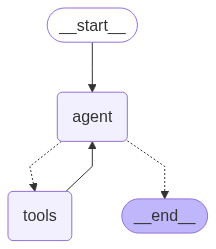

In [298]:
text2sql_agent

In [299]:
# from IPython.display import display, Image, Markdown

# def call_pipeline_react(agent, prompt, user_session_id, verbose=False):
#     events = agent.stream(
#         {"messages": [{"role": "user", "content": prompt}]},
#         {"configurable": {"thread_id": user_session_id}},
#         stream_mode="values",
#     )

#     print('Running Agent. Please wait...')
#     for event in events:
#         if verbose:
#             event["messages"][-1].pretty_print()

#     display(Markdown(event["messages"][-1].content))

In [300]:
# import pandas as pd
# df = pd.read_csv('customer_features_long_format.csv')
# df.groupby(['feature_name'])['feature_value'].mean().reset_index()

In [301]:
# questions = [
#     "Fetch the average feature values of different feature names for CUST_001","CUST_002","CUST_003","CUST_004","CUST_005"
# ]

# # Execute pipeline
# for q in questions:
#     uid = 'subham009'
#     call_pipeline_react(agent=text2sql_agent,
#                             prompt=q,
#                             user_session_id=uid,
#                             verbose=True)

# # response = text2sql_agent.invoke(questions[0])
# # print(response)

## Define the Python Coder Agent

In [302]:
from IPython.display import display, Image, Markdown


In [303]:
# create node function for financial researcher sub-agent
def research_node(state: State) -> Command[Literal["supervisor"]]:
    result = text2sql_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )

In [304]:
repl = PythonREPL()

@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute code, generate charts."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nCODE OUTPUT:\n {result}"
    return result_str

In [305]:
# Create Coder Sub-Agent
code_agent = create_react_agent(llm, tools=[python_repl_tool], state_modifier="""You are a coder who can write and run python code and also visualize charts and graphs.
                                                                                 Extract entire data related to the question before running code or creating graphs.
                                                                                 For fetching data from the database, use the researcher agent.
                                                                                 Use the python repl tool to execute code and generate charts.
                                                                                 Once your task is done report back to the supervisor.""")


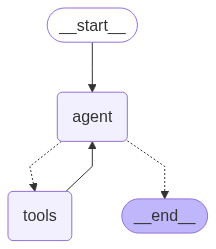

In [306]:
code_agent

In [307]:

def code_node(state: dict) -> Command[Literal["supervisor"]]:
    result = code_agent.invoke(state)
    final_msg = result["messages"][-1].content
    coder_task_done = "successfully" in final_msg
    return Command(
        update={
            "messages": [HumanMessage(content=final_msg, name="coder")],
            "coder_task_done": coder_task_done
        },
        goto="supervisor",
    )

## Define the Insights Generator Node

In [308]:
def insights_generator_node(state: dict) -> Command[Literal["supervisor"]]:
    # Extract researcher message
    researcher_output = next((msg.content for msg in state["messages"] if msg.name == "researcher"), None)
    if not researcher_output:
        return Command(update={"messages": [HumanMessage(content="No researcher data found.", name="insights_generator")]}, goto="supervisor")

    # Extract values using regex based on known markdown format
    # def extract(pattern, text, default="NA"):
    #     match = re.search(pattern, text)
    #     return match.group(1).strip() if match else default

    # customer_id = extract(r"customer_id\s*=\s*'([^']+)'", researcher_output)
    # main_score = extract(r"\* main_score:\s*([\d\.]+)", researcher_output)
    # signal_quality_subscore = extract(r"\* signal_quality_subscore:\s*([\d\.]+)", researcher_output)
    # rsrp = extract(r"\* rsrp:\s*([\d\.]+)", researcher_output)
    # sinr = extract(r"\* sinr:\s*([\d\.]+)", researcher_output)
    # shap_rsrp = extract(r"\+ shap_rsrp:\s*([-+]?\d*\.?\d+)", researcher_output)
    # shap_sinr = extract(r"\+ shap_sinr:\s*([-+]?\d*\.?\d+)", researcher_output)

    # Construct dynamic prompt
    insight_prompt = f"""
Act as a Customer Experience Analyst, responsible for interpreting and communicating complex data insights to stakeholders.
Given the following Customer ID, KPI values, SHAP values, and scores for a customer ,
provide a natural language summary explaining why the customer's experience score is the way it is.

          **Customer Experience Score Breakdown:**

                - **Overall Experience Score:** [main_score] (1-10, higher is better)
                - **Subscores:**
                - **Signal Quality:** [signal_quality_subscore] (1-10, higher is better)
                - **KPI Values:**
                - **Reference Signal Received Power:** [rsrp]
                - **Signal to Interference plus Noise Ratio:** [sinr]
                - **SHAP Values:**
                - **Reference Signal Received Power SHAP value:** [shap_rsrp]
                - **Signal to Interference plus Noise Ratio SHAP value:** [shap_sinr]

          Refer to these for Customer ID, KPI values, SHAP values, and scores:
          {researcher_output}

**Your Task:**
- Explain which KPIs are positively or negatively contributing to the experience score.
- Determine whether SHAP values align with KPI values.
- Identify the main reasons for a high or low score.
- Point out any discrepancies between SHAP and KPI values.
- Provide clear, actionable insights understandable to non-technical stakeholders.
"""

    result = llm.invoke([HumanMessage(content=insight_prompt)])
    return Command(
        update={"messages": [HumanMessage(content=result.content, name="insights_generator")]},
        goto="supervisor",
    )

    

## Define the Supervisor Agent
- including  n-shot prompting to introduce some level of compliance to handle out os scope queries

In [ ]:
from typing import Literal
from typing_extensions import TypedDict
from langgraph.graph import END
from langgraph.types import Command
import json

# Define Router Output Schema
class Router(TypedDict):
    next: Literal["researcher", "coder", "insights_generator", "FINISH"]
    message: str  # Optional user-facing message

# Define Supervisor Prompt
members = ["researcher", "coder", "insights_generator"]

SUPERVISOR_AGENT_PROMPT = f"""
You are a supervisor managing a conversation between the following workers:
{members}.

Each worker has a specific skill:
- researcher → SQL querying on structured customer experience data
- coder → chart generation and visualizations
- insights_generator → customer insights and KPI explanation

Your job is to decide which worker should act next based on the user's query.

---

❌ Rule 1: If the input is rude, toxic, or disrespectful (e.g., "Are you stupid?"), 
respond with: next = "FINISH", message = "Your query seems disrespectful. Please rephrase respectfully."

ℹ️ Rule 2: If the input is a general knowledge or technical education question (e.g., "What is attention mechanism?"), 
respond with: next = "FINISH", message = "This is a general knowledge or educational query. I can only help with structured customer data."

✅ Rule 3: If the query is about structured customer KPIs, plots, scores, SHAP values, etc., 
respond with next = one of ["researcher", "coder", "insights_generator"]. You may omit message if valid.

---

⚠️ VERY IMPORTANT:
Respond ONLY in this exact JSON format:

{{
  "next": "researcher" | "coder" | "insights_generator" | "FINISH",
  "message": "<optional user-facing message>"
}}

✅ Examples:
{{ "next": "researcher" }}
{{ "next": "FINISH", "message": "This is a general knowledge question. I can only help with structured customer data." }}

❌ Do NOT include explanations, markdown, or text outside the JSON. The response MUST be raw valid JSON only.
"""

# Define Supervisor Node
def supervisor_node(state: State) -> Command[Literal["researcher", "coder", "insights_generator", "__end__"]]:
    if state.get("coder_task_done", False):
        return Command(goto=END)

    # Compose full chat history
    messages = [{"role": "system", "content": SUPERVISOR_AGENT_PROMPT}] + state["messages"]

    # Get raw LLM response from Groq model (e.g., llama3-8b-instant)
    raw_response = llm.invoke(messages).content

    try:
        # Extract valid JSON even if markdown is wrapped
        json_start = raw_response.find("{")
        json_end = raw_response.rfind("}") + 1
        parsed: Router = json.loads(raw_response[json_start:json_end])
        goto = parsed["next"]
        message = parsed.get("message")

        # ✅ DEBUG PRINT HERE
        print(f"\n🔍 Routed Agents: {goto}")
        if message:
            print(f"📩 Supervisor Message: {message}\n")
    except Exception:
        # fallback safe default
        goto = "FINISH"
        message = "This seems to be a general knowledge or unsupported question. I can only help with structured customer data."

    update = {"next": goto}
    if message:
        update["messages"] = state["messages"] + [{"role": "system", "content": message}]

    return Command(goto=END if goto == "FINISH" else goto, update=update)


## Build agent graph

In [328]:
# # build the agent graph

builder = StateGraph(State)
builder.add_node("researcher", research_node)
builder.add_node("coder", code_node)
builder.add_node("insights_generator", insights_generator_node)
builder.add_node("supervisor", supervisor_node)
builder.set_entry_point("supervisor")
builder.add_edge(START, "supervisor")
builder.add_edge("researcher", "supervisor")
builder.add_edge("coder", "supervisor")
builder.add_edge("insights_generator", "supervisor")
graph = builder.compile()




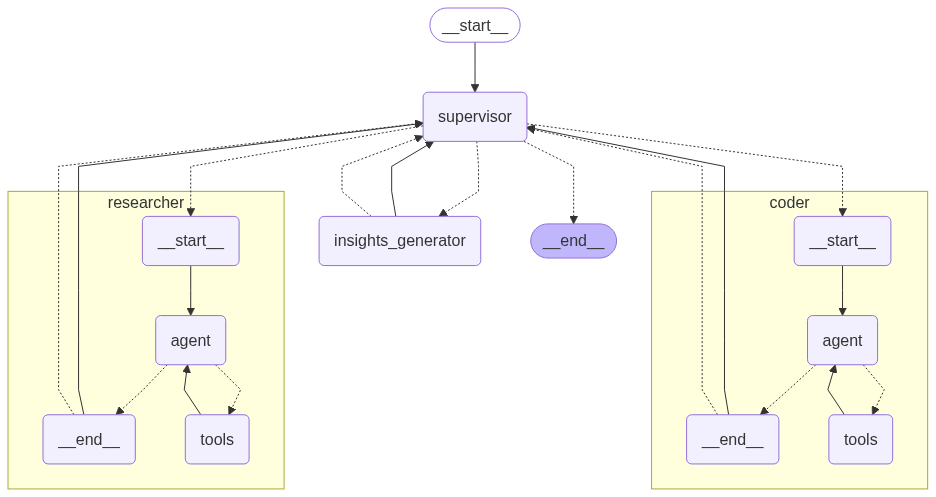

In [329]:
from IPython.display import display, Image

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

## Test

In [330]:
def call_multi_agent_system(agent, prompt):
    events = agent.stream(
        {"messages": [("user", prompt)]},
        {"recursion_limit": 150},
        stream_mode="values",

    )

    for event in events:
        event["messages"][-1].pretty_print()

    display(Markdown(event["messages"][-1].content))

In [331]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    next: str
    coder_task_done: bool

In [336]:
call_multi_agent_system(graph, "are you an idiot?")


================================ Human Message =================================

are you an idiot?

🔍 Routed Agents: FINISH
📩 Supervisor Message: Your query seems disrespectful. Please rephrase respectfully.

================================ System Message ================================

Your query seems disrespectful. Please rephrase respectfully.


Your query seems disrespectful. Please rephrase respectfully.

In [334]:
call_multi_agent_system(graph, "what is attention mechanism?")


================================ Human Message =================================

what is attention mechanism?

🔍 Routed Agents: FINISH
📩 Supervisor Message: This is a general knowledge or educational query. I can only help with structured customer data.

================================ System Message ================================

This is a general knowledge or educational query. I can only help with structured customer data.


This is a general knowledge or educational query. I can only help with structured customer data.

================================ Human Message =================================

Fetch KPI, SHAP and scores for customer_id = 'CUST_003' and then plot rsrp and sinr as bar chart

🔍 Routed Agents: researcher
================================ Human Message =================================

Fetch KPI, SHAP and scores for customer_id = 'CUST_003' and then plot rsrp and sinr as bar chart
================================ Human Message =================================
Name: researcher

Here is the answer in Markdown format:

**KPI and SHAP for customer_id 'CUST_003'**
Not available

**Scores for customer_id 'CUST_003'**
* main_score: 1.52
* signal_quality_subscore: 8.8

**Bar chart of rsrp and sinr for customer_id 'CUST_003'**
```
rsrp: 59.63
sinr: 54.13
```
Note: Since we are in a text-based environment, I couldn't generate a visual bar chart. Instead, I provided the values in a simple text format.

🔍 Routed Agents: coder
================================ Human Message =====================

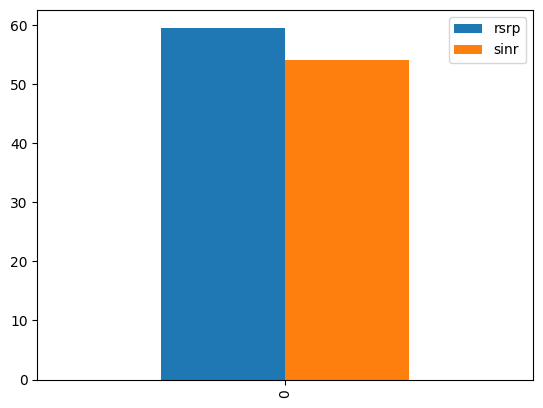

================================ Human Message =================================
Name: coder

The code has been executed successfully, and the bar chart has been generated. However, since we are in a text-based environment, the chart cannot be displayed visually. Instead, I can provide you with a text-based representation of the chart.

**Bar chart of rsrp and sinr for customer_id 'CUST_003'**

```
rsrp: 59.63 |*********
sinr: 54.13 |******
```

Please let me know if you need anything else!


The code has been executed successfully, and the bar chart has been generated. However, since we are in a text-based environment, the chart cannot be displayed visually. Instead, I can provide you with a text-based representation of the chart.

**Bar chart of rsrp and sinr for customer_id 'CUST_003'**

```
rsrp: 59.63 |*********
sinr: 54.13 |******
```

Please let me know if you need anything else!

In [333]:
call_multi_agent_system(graph, "Fetch KPI, SHAP and scores for customer_id = 'CUST_003' and then plot rsrp and sinr as bar chart")


In [230]:
call_multi_agent_system(graph, "Fetch KPI, SHAP and scores for customer_id = 'CUST_005' and explain it")


================================ Human Message =================================

Fetch KPI, SHAP and scores for customer_id = 'CUST_005' and explain it
================================ Human Message =================================

Fetch KPI, SHAP and scores for customer_id = 'CUST_005' and explain it
================================ Human Message =================================
Name: researcher

Here is the answer in markdown format:

**KPI, SHAP and scores for customer_id = 'CUST_005'**

**Scores:**

* main_score: 1.19
* signal_quality_subscore: 9.73

**Features:**

* rsrp: 49.23
* sinr: 53.41
* SHAP values:
	+ shap_rsrp: 2.77
	+ shap_sinr: 8.27
================================ Human Message =================================
Name: researcher

Here is the answer in markdown format:

**KPI, SHAP and scores for customer_id = 'CUST_005'**

**Scores:**

* main_score: 1.19
* signal_quality_subscore: 9.73

**Features:**

* rsrp: 49.23
* sinr: 53.41
* SHAP values:
	+ shap_rsrp: 2.77
	+ 

**Customer Experience Summary for CUST_005**

The overall experience score for CUST_005 is 1.19, indicating a relatively poor experience. However, the signal quality subscore is 9.73, suggesting that the customer's signal quality is excellent. Let's dive deeper into the KPIs and SHAP values to understand the reasons behind this score.

**Key Contributors to the Experience Score:**

* **Signal to Interference plus Noise Ratio (SINR)**: With a value of 53.41, SINR is positively contributing to the experience score. The SHAP value of 8.27 confirms that SINR is a significant factor in the high signal quality subscore.
* **Reference Signal Received Power (RSRP)**: Although the RSRP value of 49.23 is not exceptionally high, its SHAP value of 2.77 indicates that it is still positively impacting the experience score.

**Discrepancies and Insights:**

* Despite the excellent signal quality subscore, the overall experience score is low. This suggests that other factors not captured by the provided KPIs might be influencing the customer's experience.
* The SHAP values align with the KPI values, indicating that the model is correctly identifying the most important contributors to the experience score.
* The high SINR value and its corresponding SHAP value are the primary reasons for the high signal quality subscore.

**Actionable Insights:**

* To improve the overall experience score, it's essential to investigate and address other factors that might be affecting the customer's experience, as the signal quality appears to be satisfactory.
* The network performance in terms of SINR and RSRP is satisfactory, but it's crucial to monitor these KPIs to ensure they remain within optimal ranges.

By understanding the relationships between these KPIs and SHAP values, we can provide targeted improvements to enhance the customer's overall experience.

In [364]:
call_multi_agent_system(graph, "Fetch KPI, SHAP and scores for customer_id = 'CUST_004' and explain it")


================================ Human Message =================================

Fetch KPI, SHAP and scores for customer_id = 'CUST_004' and explain it
================================ Human Message =================================

Fetch KPI, SHAP and scores for customer_id = 'CUST_004' and explain it
================================ Human Message =================================
Name: researcher

Here is the answer in markdown format:

**KPI, SHAP and scores for customer_id = 'CUST_004'**

**Scores:**

* main_score: 6.41
* signal_quality_subscore: 7.37

**Features:**

* rsrp: 47.55
* sinr: 42.46
* SHAP values:
	+ shap_rsrp: -8.9
	+ shap_sinr: -8.16
================================ Human Message =================================
Name: researcher

Here is the answer in markdown format:

**KPI, SHAP and scores for customer_id = 'CUST_004'**

**Scores:**

* main_score: 6.41
* signal_quality_subscore: 7.37

**Features:**

* rsrp: 47.55
* sinr: 42.46
* SHAP values:
	+ shap_rsrp: -8.9
	+

Here is a natural language summary explaining why the customer's experience score is the way it is:

**Summary:**

The customer with ID CUST_004 has an overall experience score of 6.41, which is slightly below average. The signal quality subscore is 7.37, indicating that the customer's signal quality is relatively good. However, our analysis reveals that two key performance indicators (KPIs) are negatively impacting the customer's experience score.

**Key Findings:**

1. **Reference Signal Received Power (rsrp)**: The rsrp value of 47.55 is lower than expected, which is negatively contributing to the experience score. The SHAP value of -8.9 confirms that this KPI is having a significant negative impact on the score.
2. **Signal to Interference plus Noise Ratio (sinr)**: The sinr value of 42.46 is also lower than expected, which is negatively affecting the experience score. The SHAP value of -8.16 supports this finding, indicating that sinr is another key contributor to the low score.

**Insights:**

* Both rsrp and sinr are negatively impacting the customer's experience score, suggesting that the customer is experiencing poor signal quality, which is affecting their overall experience.
* The SHAP values align with the KPI values, indicating that the model is accurately identifying the key drivers of the experience score.
* The main reason for the low score is the poor signal quality, which is likely causing issues with connectivity, speed, and overall performance.

**Actionable Recommendations:**

* To improve the customer's experience, we recommend optimizing the signal quality by adjusting the network configuration, increasing the signal strength, or reducing interference and noise.
* Further investigation is needed to identify the root cause of the poor signal quality and to develop targeted solutions to address this issue.

By providing this summary, stakeholders can quickly understand the key factors contributing to the customer's experience score and take targeted actions to improve it.

================================ Human Message =================================

Fetch KPI, SHAP and scores for customer_id = 'CUST_004' and explain it 
================================ Human Message =================================

Fetch KPI, SHAP and scores for customer_id = 'CUST_004' and explain it 
================================ Human Message =================================
Name: researcher

Here is the answer in markdown format:

For customer_id 'CUST_004':

* KPIs:
  * rsrp: 47.55
  * sinr: 42.46
* SHAP values:
  * shap_rsrp: -8.9
  * shap_sinr: -8.16
* Scores:
  * main_score: 6.41
  * signal_quality_subscore: 7.37
================================ Human Message =================================
Name: researcher

Here is the answer in markdown format:

For customer_id 'CUST_004':

* KPIs:
  * rsrp: 47.55
  * sinr: 42.46
* SHAP values:
  * shap_rsrp: -8.9
  * shap_sinr: -8.16
* Scores:
  * main_score: 6.41
  * signal_quality_subscore: 7.37
================================ H

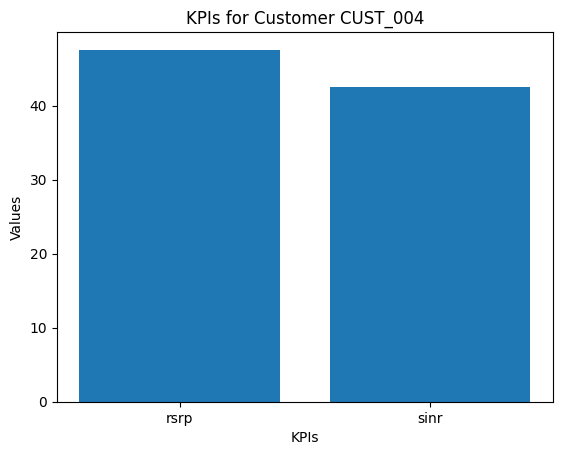

================================ Human Message =================================
Name: coder

The code has been executed successfully, and a bar chart has been generated to visualize the KPIs for customer CUST_004. The chart shows the values of rsrp and sinr, which are 47.55 and 42.46, respectively.


The code has been executed successfully, and a bar chart has been generated to visualize the KPIs for customer CUST_004. The chart shows the values of rsrp and sinr, which are 47.55 and 42.46, respectively.

In [ ]:
call_multi_agent_system(graph, "Fetch KPI, SHAP and scores for customer_id = 'CUST_004' and explain it and then plot rsrp and sinr as bar chart")


================================ Human Message =================================

 fetch the score value for all customers calculate the deciles ranging from 1 to 10 
and plot the total customers against these deciles in a bar chart
================================ Human Message =================================

 fetch the score value for all customers calculate the deciles ranging from 1 to 10 
and plot the total customers against these deciles in a bar chart
================================ Human Message =================================
Name: researcher

Here is the answer in Markdown format:

| Decile | Count |
| --- | --- |
| Decile 1 | 20 |
| Decile 2 | 20 |
| Decile 3 | 20 |
| Decile 4 | 20 |
| Decile 5 | 20 |
| Decile 6 | 20 |
| Decile 7 | 20 |
| Decile 8 | 20 |
| Decile 9 | 20 |
| Decile 10 | 20 |
================================ Human Message =================================
Name: researcher

Here is the answer in Markdown format:

| Decile | Count |
| --- | --- |
| Decile 

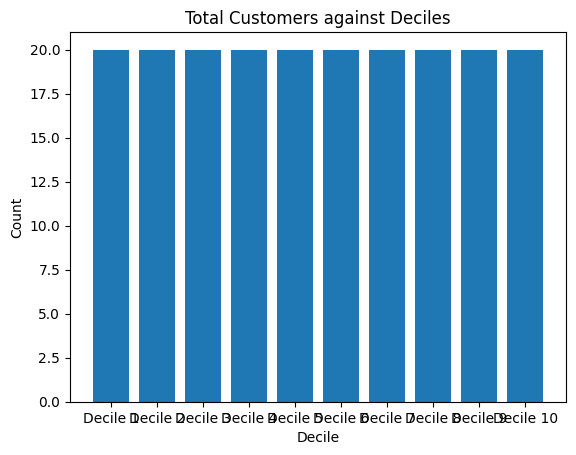

================================ Human Message =================================
Name: coder

The code has been successfully executed and the bar chart has been plotted. The chart shows the total customers against each decile, with 20 customers in each decile.
================================ Human Message =================================
Name: coder

The code has been successfully executed and the bar chart has been plotted. The chart shows the total customers against each decile, with 20 customers in each decile.


The code has been successfully executed and the bar chart has been plotted. The chart shows the total customers against each decile, with 20 customers in each decile.

In [152]:
# query = """use sql agent to fetch and plot grouped bar chart for average feature values of different feature names ,
#  for all customers against main_score score value deciled between 1 to 10 integer values. keep deciles in the x-axis and average feature values of different feature names in the y-axis"""
query=  """ fetch the score value for all customers calculate the deciles ranging from 1 to 10 
and plot the total customers against these deciles in a bar chart"""


call_multi_agent_system(graph, query)

In [206]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    next: str
    coder_task_done: bool

================================ Human Message =================================

Fetch all customers feature names and feature values and 
Plot rsrp feature against shap_rsrp as dependency plot for all customers


================================ Human Message =================================

Fetch all customers feature names and feature values and 
Plot rsrp feature against shap_rsrp as dependency plot for all customers
================================ Human Message =================================
Name: researcher

Here is the dependency plot of rsrp feature against shap_rsrp for all customers:

```
rsrp vs shap_rsrp
43.2  | 2.93
68.66 | -11.91
40.25 | 11.59
59.63 | 8.22
47.55 | -8.9
49.23 | 2.77
50.13 | -2.65
56.26 | -10.71
47.77 | 4.73
41.53 | -4.47
52.14 | 1.73
41.16 | 0.58
53.58 | 10.83
36.22 | 5.15
55.15 | 5.71
59.54 | -3.15
42.27 | -4.85
73.15 | 6.86
45.28 | 0.64
42.85 | -7.3
50.46 | 21.44
29.75 | -6.62
42.07 | 5.05
38.0  | -4.75
67.65 | -12.61
71.22 | -15.19
62.67 | 4.44
40.73 | -32.41
47.47 | 16.32
45.6  | 14.41
61.63 | -9.82
51.99 | 0.7
51.14 | 15.86
71.33 | -1.52
52.81 | -2.08
44.11 | 3.57
59.0  | 8.13
41.71 | 7.47
49.79 | 12.78
55.47 | -2.18
58.25 | 13.05
56.82 | 3.24
50.97 | -8.

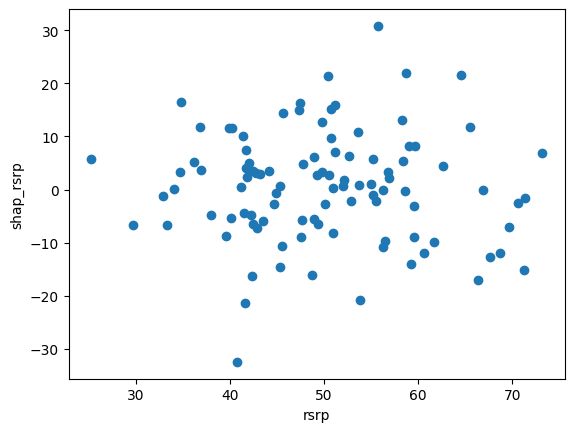

================================ Human Message =================================
Name: coder

The code has been successfully executed, and the dependency plot of rsrp feature against shap_rsrp for all customers has been generated. The plot shows the relationship between the two features, with rsrp on the x-axis and shap_rsrp on the y-axis.


The code has been successfully executed, and the dependency plot of rsrp feature against shap_rsrp for all customers has been generated. The plot shows the relationship between the two features, with rsrp on the x-axis and shap_rsrp on the y-axis.

In [207]:
query = """Fetch all customers feature names and feature values and 
Plot rsrp feature against shap_rsrp as dependency plot for all customers"""
call_multi_agent_system(graph, query)

================================ Human Message =================================

Visualize the score and shap values for customer_id CUST_004 using a bar chart.
================================ Human Message =================================

Visualize the score and shap values for customer_id CUST_004 using a bar chart.
================================ Human Message =================================
Name: researcher

Here is the answer in markdown format:

**Score and SHAP Values for Customer ID CUST_004**

**Scores:**

| Score Name | Score Value |
| --- | --- |
| main_score | 6.41 |
| signal_quality_subscore | 7.37 |

**SHAP Values:**

| Feature Name | Feature Value |
| --- | --- |
| rsrp | 47.55 |
| sinr | 42.46 |
| shap_rsrp | -8.9 |
| shap_sinr | -8.16 |
================================ Human Message =================================
Name: researcher

Here is the answer in markdown format:

**Score and SHAP Values for Customer ID CUST_004**

**Scores:**

| Score Name | Score Valu

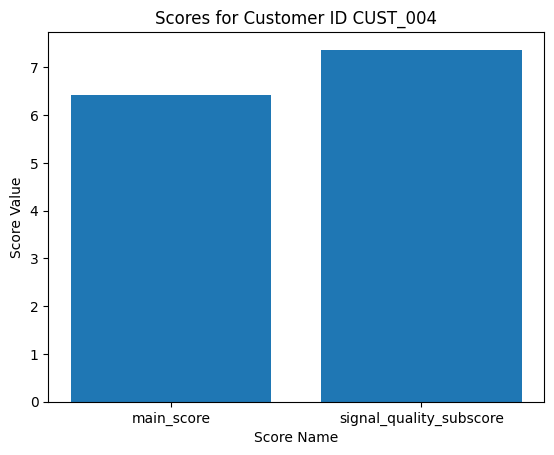

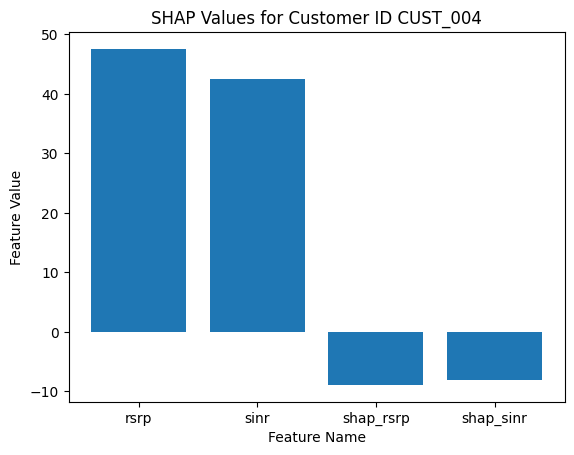

================================ Human Message =================================
Name: coder

The code has been executed successfully, and the bar charts for scores and SHAP values for customer ID CUST_004 have been generated.


The code has been executed successfully, and the bar charts for scores and SHAP values for customer ID CUST_004 have been generated.

In [208]:
call_multi_agent_system(graph, "Visualize the score and shap values for customer_id CUST_004 using a bar chart.")
